In [17]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/yashakb/env-yashakb/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'plt', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Кластеризация

Ранее в курсе все время рассматривались задачи в следующей постановке: задана матрица "объекты-признаки", столбец ответов, требуется построить некоторую модель, находящую между ними зависимость. Это так называемый класс задач обучения с учителем (supervised learning), то есть задач, в которых для объектов известны метки, которые могут быть получены от экспертов, размечающих объекты. 

Рассмотрим следующую задачу: допустим есть сотовый оператор, который хочет объединять похожих пользователей в группы.

Можно было бы решать задачу классификации, разметив некоторое количество пользователей, т.е. указав класс каждого из них, однако:
- разметка пользователей — дорогостоящая операция;
- необходимы большие объемы разметки;
- в ней могут присутствовать ошибки;
- непонятно, сколько групп пользователей существует;
- непонятно, что такое "похожие" пользователи (примерно одинаковое количество смс? звонков? распределение количества звонков в течение месяца? что-то ещё?)

В связи с этими проблемами подобные задачи выделяют в отдельный класс задач обучения без учителя, т.е. задач, в которых для объектов неизвестны метки, и работать приходится только с матрицей "объект-признак".

Как измерять качество? Если все же известно какое-то количество размеченных данных — то по ним. Иначе использовать информацию о самих кластерах, например, среднее расстояние точек внутри кластера и пр. 

Как выбирать количество кластеров? Построить кластеризацию для разных значений *K* и выбрать то, после которого качество перестает заметно меняться.

Как определять "похожесть" объектов? Как правило, в задачах обучения без учителя задается функция **расстояния** между объектами $\rho(a, b)$, которая для любых 2 объектов $a, b$ позволяет получить некоторое число, являющееся оценкой того, насколько объекты непохожи, например:
* $\rho(a, b) = \sqrt{\sum_{j = 1}^d (a^j - b^j)^2}$ — **евклидово расстояние**, вычисляется по теореме Пифагора. Чем выше значение, тем дальше находятся объекты друг от друга.
* $\rho(a, b) = \sum_{j = 1}^d |a^j - b^j|$ — **метрика городских кварталов** или **манхэттенское расстояние** (имеет еще множество других имён). Получила своё название в честь планировки прямоугольных городов, в которых количество кварталов, которые необходимо пройти, чтобы попасть из точки A в точку B не зависит от выбранного пути:
![](https://upload.wikimedia.org/wikipedia/commons/0/08/Manhattan_distance.svg)


### K-Means (алгоритм K средних)

*K*, фигурирующее в названии алгоритма, означает количество кластеров.

Последовательность действий следующая:
 1. Выбрать *K* случайных точек и назначить их центрами кластеров.
 2. Отнести каждый объект к тому кластеру, чей центр ближе — таким образом получаем некоторое разбиение всех объектов на кластеры.
 3. Пересчитать центры кластеров — для каждого центром назначим *среднюю* точку этого кластера (в соответствии с разбиением из п. 2)
 4. Повторять шаги 2 — 4, пока не будет выполнен критерий останова.

На примере: 
![](http://i.imgur.com/D9n5Q3e.png)

Критерии останова: 
 - Пока ситуация "продолжает меняться" — т.е пока хоть какие-то точки продолжают менять свои метки или центры кластеров не стабилизируются.
 - Фиксированное количество итераций алгоритма.

### Агломеративная кластеризация (один из видов иерархической кластеризации)

1. В начале считаем что каждая точка — отдельный кластер.
2. Находим два ближайших кластера, объединяем их между собой
3. Повторяем шаг 2, пока не выполнен критерий останова.

Мы знаем функцию расстояния между точками, но как считать расстояние между **кластерами**?
 - Расстояние "ближнего" соседа — минимальное из попарных расстояний
 ![](http://i062.radikal.ru/1605/60/fad9821d120d.png)
 - Расстояние "дальнего" соседа — максимальное из попарных расстояний
 ![](http://s05.radikal.ru/i178/1605/ee/84904c48fcc4.png)
 - Среднее расстояние между точками кластеров
![](http://s06.radikal.ru/i179/1605/15/1604bdbbd5d8.png)
 - Расстояние между центрами кластеров
 ![](http://i057.radikal.ru/1605/12/fa546960de8f.png)
 - и пр.
 
Рассмотрим на примере, как работает алгоритм агломеративной кластеризации.

Пусть изначально точки имели следующее расположение:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Clusters.svg/250px-Clusters.svg.png)

Тогда агломеративная кластеризация будет следующей:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Hierarchical_clustering_simple_diagram.svg/418px-Hierarchical_clustering_simple_diagram.svg.png)

Теперь сравним результаты различных методов кластеризации на данных различной природы. В качестве функции расстояния будем использовать евклидово расстояние.

In [11]:
from sklearn.cluster import KMeans
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [12]:
np.random.seed(0)

Сгенерируем 4 вида данных:

In [13]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
ds = [noisy_circles, noisy_moons, blobs, no_structure]

In [14]:
def plot_clusterization(k, ds):
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)

    clustering_names = ['KMeans', 'AgglomerativeClustering']

    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    plot_num = 1

    for i_dataset, dataset in enumerate(ds):
        X, y = dataset
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        # create clustering estimators
        km = KMeans(n_clusters=k)
        ac = AgglomerativeClustering(n_clusters=k)

        clustering_algorithms = [km, ac]

        for name, algorithm in zip(clustering_names, clustering_algorithms):
            algorithm.fit(X)
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            plt.subplot(4, len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)
            plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

            if hasattr(algorithm, 'cluster_centers_'):
                centers = algorithm.cluster_centers_
                center_colors = colors[:len(centers)]
                plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            plt.legend()
            plt.xticks(())
            plt.yticks(())
            plot_num += 1

    plt.show()

In [19]:
?AgglomerativeClustering

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


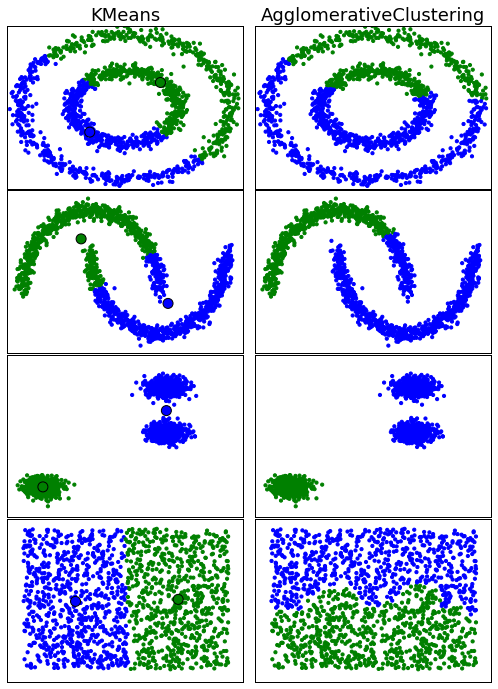

In [15]:
plot_clusterization(k=2, ds=ds)

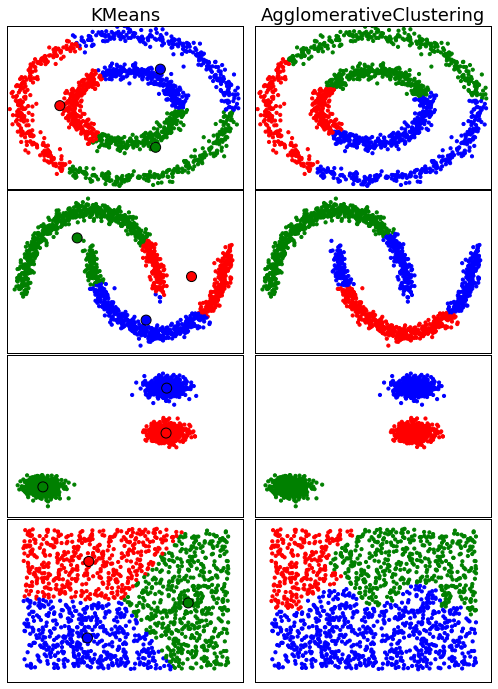

In [16]:
plot_clusterization(k=3, ds=ds)

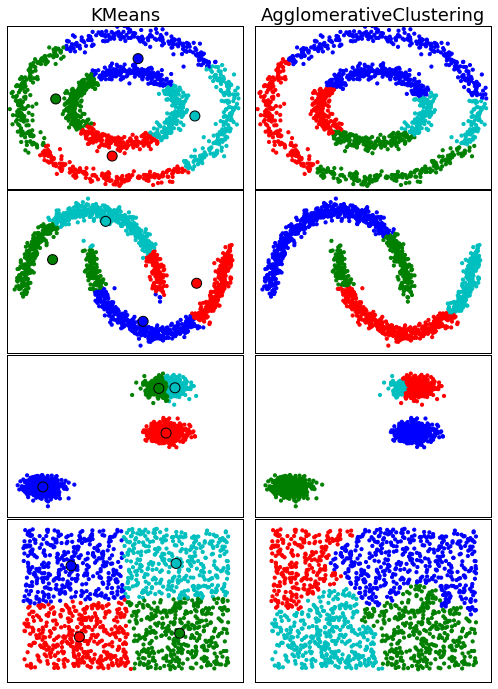

In [17]:
plot_clusterization(k=4, ds=ds)

In [3]:
data = pd.read_csv("train.csv")

In [4]:
from sklearn.utils import shuffle
from sklearn.preprocessing import scale

In [5]:
sdata = shuffle(data, random_state=321)

In [6]:
real_features = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI", "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
                 "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
discrete_features = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]
cat_features = data.columns.drop(real_features).drop(discrete_features).drop(["Id", "Response"]).tolist()

Методы sklearn не принимают матрицы с пропусками (nan). Чтобы избежать этой проблемы, не будем рассматривать признаки, которые имеют много пропусков (последние четыре в списке вещественных признаков). Кроме того, ограничимся расмотрением вещественных признаков.

В следующей ячейке мы отбираем нужные признаки, затем находим объекты, у которых все признаки известны (нет пропусков в выбанных признаках), а затем создаем отдельно матрицу объекты-признаки для работы методов понижения размерности и отдельно вектор правильных ответов на этих объектах: data_subset и response_subset. Кроме того, мы дополнительно стандартизуем нашу маленькую выборку, потому что методы понижения размерности очень чувствительны к разномасштабным данным (это отдельно указано в [туториале](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) в sklearn)

In [7]:
subset_l  = 1000
selected_features = real_features[:-4]
objects_with_nan = sdata.index[np.any(np.isnan(sdata[selected_features].values), axis=1)]   
data_subset = scale(sdata[selected_features].drop(objects_with_nan, axis=0)[:subset_l])
response_subset = sdata["Response"].drop(objects_with_nan, axis=0)[:subset_l]

Будем строить визуализацию с помощью наибоее популярных методов нелинейного понижения размерности: t-SNE и MDS.

In [8]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

In [9]:
tsne = TSNE(random_state=321)
tsne_representation = tsne.fit_transform(data_subset)

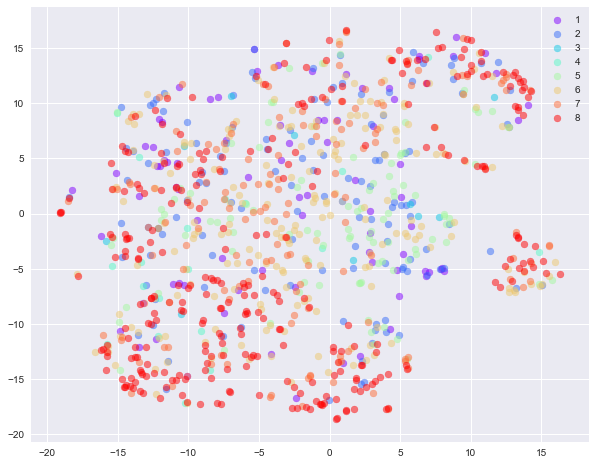

In [19]:
figsize(10,8)
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, c in zip(set(data.Response), colors):
    plt.scatter(tsne_representation[response_subset.values==y, 0], 
                tsne_representation[response_subset.values==y, 1], c=c, alpha=0.5, label=str(y))
_ = plt.legend()

In [11]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances

In [12]:
mds = MDS(random_state=321)
MDS_transformed = mds.fit_transform(data_subset)

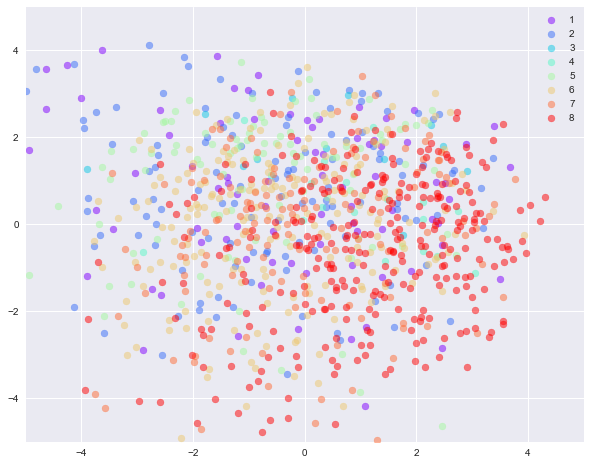

In [20]:
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed[response_subset.values==y, 0], 
                MDS_transformed[response_subset.values==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()
plt.xlim(-5, 5)   # масса точек концентриурется в этом масштабе
_ = plt.ylim(-5, 5)   # рекомендуем сначала отобразить визуализацию целиком, 
# а затем раскомментировать эти строки.

Для построения представления можно пробовать разные метрики, их список доступен в [документации scipy](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html) (потому что sklearn использует метрики scipy).

В t_SNE метрику можно указать при создании объекта класса TSNE, в MDS это реализуется несколько сложнее. Нужно указать metric="precomputed", а в fit_transform подать не матрицу объектов, а матрицу попарных расстояний между объектами. Создать ее можно с помощью функции pairwise_distances с параметрами: матрица объектов, метрика.

Применим MDS с косинусной метрикой:

In [21]:
mds = MDS(dissimilarity="precomputed", random_state=321)
MDS_transformed_cos = mds.fit_transform(pairwise_distances(data_subset, metric="cosine"))

/Users/yashakb/env-yashakb/lib/python2.7/site-packages/sklearn/manifold/mds.py:396: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


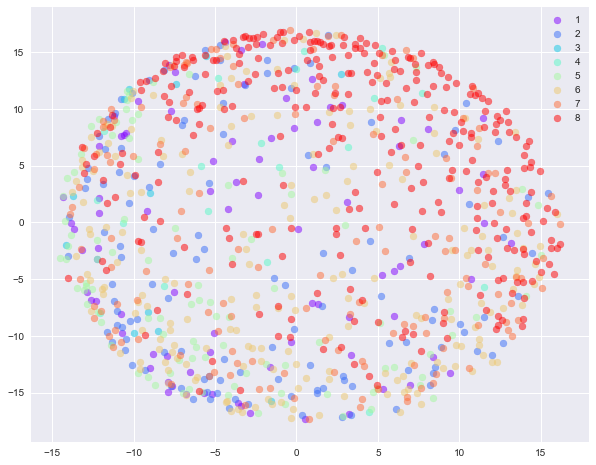

In [22]:
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed_cos[response_subset.values[:subset_l]==y, 0], 
                MDS_transformed_cos[response_subset.values[:subset_l]==y, 1], 
                c=c, alpha=0.5, label=str(y))
_ = plt.legend()

Мы видим, что точки с большим значением Response хорошо отделяются от точек в маленьким значением целевого признака, а вот промежуточные значения сильно перемешаны.